In [2]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid", palette="muted")


from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import VotingClassifier

from sklearn.grid_search import GridSearchCV

from sklearn.metrics import accuracy_score
import xgboost as xgb

from sklearn.feature_selection import RFE

%matplotlib inline

# Read data

In [3]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
all_df = train_df.append(test_df)

all_df['is_test'] = all_df.Survived.isnull()
all_df.index = all_df.Survived

In [4]:
all_df.shape

(1309, 13)

# Target variable

Target variable is **Survived**.

# Quality metric

Your score is the percentage of passengers you correctly predict. That means - **accuracy**.

# Model

## One variable model
Let's build a very simple model, based on one variable.
That nobody will survived.

In [5]:
def select_features(df):
    non_obj_feats = df.columns[ df.dtypes != 'object' ]
    black_list = ['PassengerId', 'is_test', 'Survived']
    
    return [feat for feat in non_obj_feats if feat not in black_list ]

def get_X_y(df):
    feats = select_features(df)
    
    X = df[feats].values
    y = df.index.values.astype(int)
    
    return X, y

def check_quality(model, X, y, n_folds=5, random_state=0, shuffle=True):
    skf = StratifiedKFold(y, n_folds=n_folds, random_state=random_state, shuffle=shuffle)
    scores = []
    
    for train_index, test_index in skf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        
        scores.append(score)
        
    return np.mean(scores), np.std(scores)

def train_and_verify(df, model):
    X, y = get_X_y( df[ df.is_test == False ] )
    return check_quality(model, X, y)

def predict_and_save(df, model, file_name):
    df_test = df[ df.is_test == True ]
    X_test = df_test[ select_features( df_test ) ].values
    
    df_subm = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived"   : model.predict(X_test)
    })
    
    df_subm.to_csv(file_name, index=False)

def iteration_modeling(all_df, model = RandomForestClassifier(), iterations=30):
    res = [train_and_verify(all_df, model)[0] for x in range(iterations)]
    return {'min': np.min(res), 'mean': np.mean(res), 'max': np.max(res) }

def get_importance_features(data, model, limit):
    X,y = get_X_y(data)
    cols = select_features(data)
    
    model.fit(X, y)
    feats = pd.DataFrame(model.feature_importances_, index=data[cols].columns)
    feats = feats.sort_values(by=[0], ascending=False) [:limit]
    return feats.rename(columns={0:'feature'})
    
def draw_importance_features(data, model=RandomForestClassifier(), limit=30):
    feats = get_importance_features(data, model, limit)
    feats.plot(kind='bar', figsize=(20, 8))
    
def handle_cat_var(all_df, name):
    unique_values = all_df[name].unique()
    
    #========= probability
    for value in unique_values:
        x_all = all_df[ (all_df[name] == value) ].shape[0]
        x_survived = all_df[ (all_df[name] == value) & (all_df.index == 1) ].shape[0]

        all_df['{0}_{1}_prob_surv'.format(name, value)] = x_survived / float(x_all)
        all_df['{0}_{1}_prob_not_surv'.format(name, value)] = 1.0 - all_df['{0}_{1}_prob_surv'.format(name, value)]
        
    #========= category to unique id
    name_idx, name_labes = pd.factorize(all_df[name])
    all_df['{0}_idx'.format(name)] = name_idx
    
    #========= one hot encoding
    first_value = unique_values[0]
    if '{0}_{1}'.format(name, first_value) not in all_df:
        one_hot = pd.get_dummies( all_df[name], prefix=name)
        all_df = pd.concat( [all_df, one_hot], axis=1 )
        
    return all_df

In [6]:
class SingleVariableModel(BaseEstimator, ClassifierMixin):
    def __init__(self, seed=1):
        np.random.seed(seed)

    def fit(self, X, y):
        return self
        
    def predict(self, X):
        return [0] * len(X)
    
    def __repr__(self):
        return 'SingleVariableModel'

## Run & evoluate single variable model

In [7]:
train_and_verify(all_df, SingleVariableModel())

(0.61616490890978648, 0.0015536004208290756)

**What do you think about this result?**

## Let's build more advanced model

### Missing values
There're several methods how to manage missing values, let's fill out -1.

In [8]:
all_df.fillna(-1, inplace=True)

In [9]:
iteration_modeling(all_df)

{'max': 0.70710216764599587,
 'mean': 0.68766972824543116,
 'min': 0.66217033414225968}

The result looks better than previous one (**0.616** vs **0.68**).  
Let's improve it... by using those features `['Cabin', 'Embarked', 'Name', 'Sex', 'Ticket']`

{'max': 0.81369422584046236, 'mean': 0.79765920499196097, 'min': 0.78233370109160738}


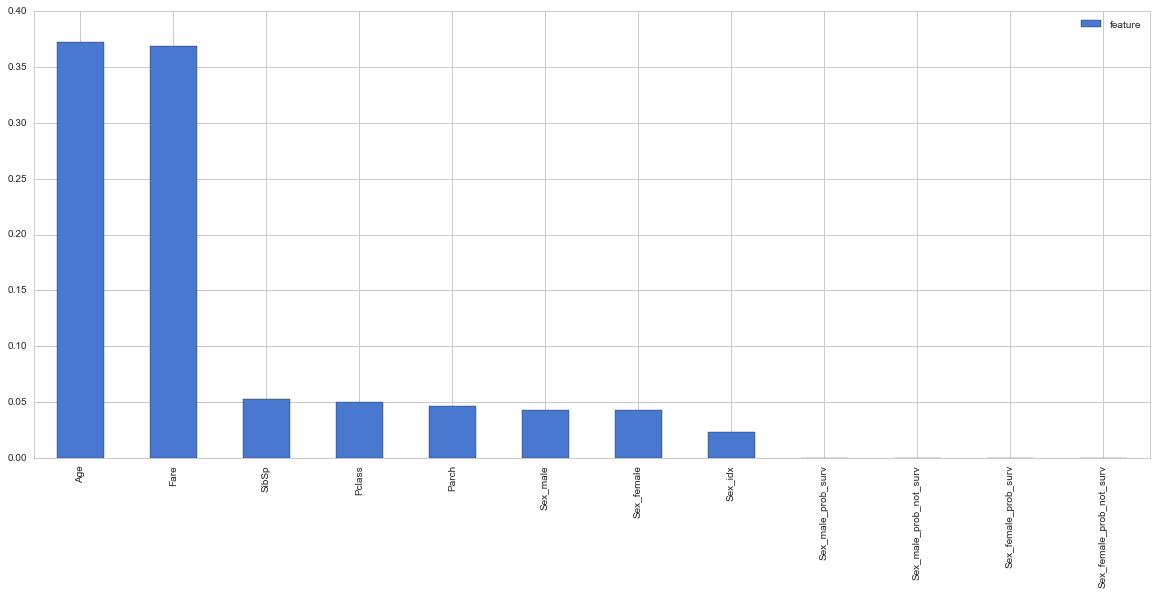

In [10]:
all_df = handle_cat_var(all_df, 'Sex')
print iteration_modeling(all_df)

draw_importance_features(all_df)

The result looks better than previous one (**0.68** vs **0.79**).  

Next features wchich could improve quality the model

In [11]:
all_df[ ['Name', 'Cabin', 'Embarked', 'Ticket'] ].head()

,Name,Cabin,Embarked,Ticket
Survived,,,,
0.0,"Braund, Mr. Owen Harris",-1,S,A/5 21171
1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C85,C,PC 17599
1.0,"Heikkinen, Miss. Laina",-1,S,STON/O2. 3101282
1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",C123,S,113803
0.0,"Allen, Mr. William Henry",-1,S,373450


Prefix in names, let's try use it.

In [12]:
all_df['prefix_name'] = all_df['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip().lower() )

In [13]:
all_df['prefix_name'].value_counts()

mr              757
miss            260
mrs             197
master           61
dr                8
rev               8
col               4
ms                2
mlle              2
major             2
lady              1
sir               1
mme               1
capt              1
don               1
jonkheer          1
dona              1
the countess      1
Name: prefix_name, dtype: int64

Let's use **mr**, **miss**, **mrs**, **master** and *other*

In [14]:
all_df['prefix_name_'] = all_df['prefix_name'].map(lambda x: x if x in ["mr", "miss", "mrs", "master"] else "other" )

In [15]:
all_df['prefix_name_'].value_counts()

mr        757
miss      260
mrs       197
master     61
other      34
Name: prefix_name_, dtype: int64

{'max': 0.82492397475412138, 'mean': 0.81073444318075549, 'min': 0.80021086699101751}


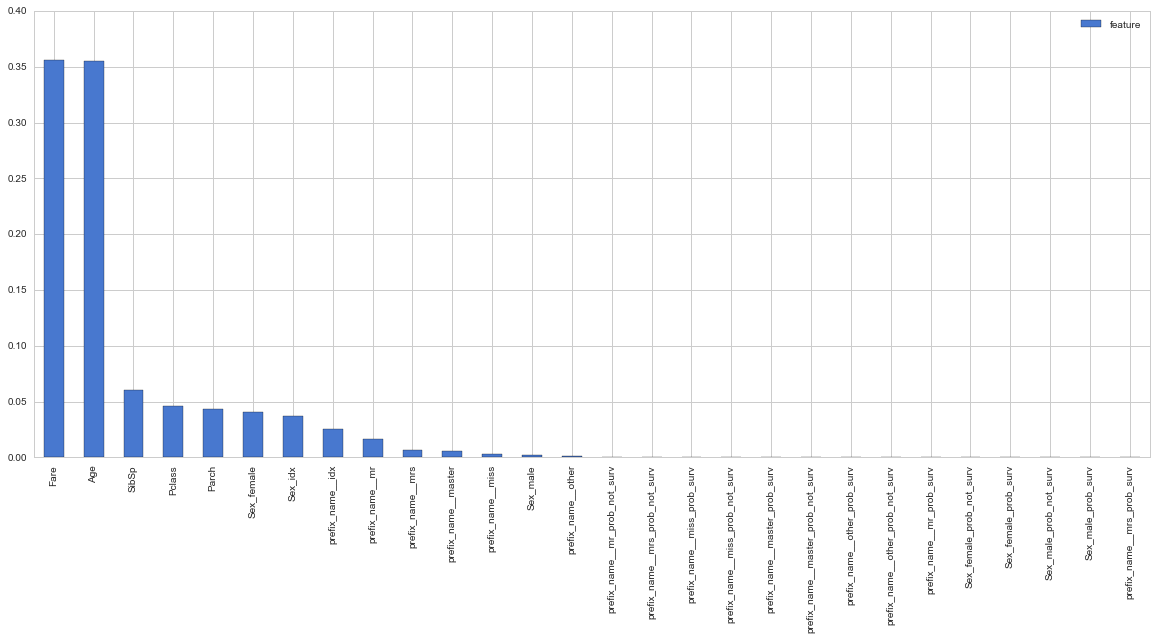

In [16]:
all_df = handle_cat_var(all_df, 'prefix_name_')
print iteration_modeling(all_df)

draw_importance_features(all_df)

The result looks better than previous one (**0.79** vs **0.81**).  

Let's extract first letter from **Cabin**

{'max': 0.8260603371814963, 'mean': 0.81201782735126227, 'min': 0.80242032465572755}


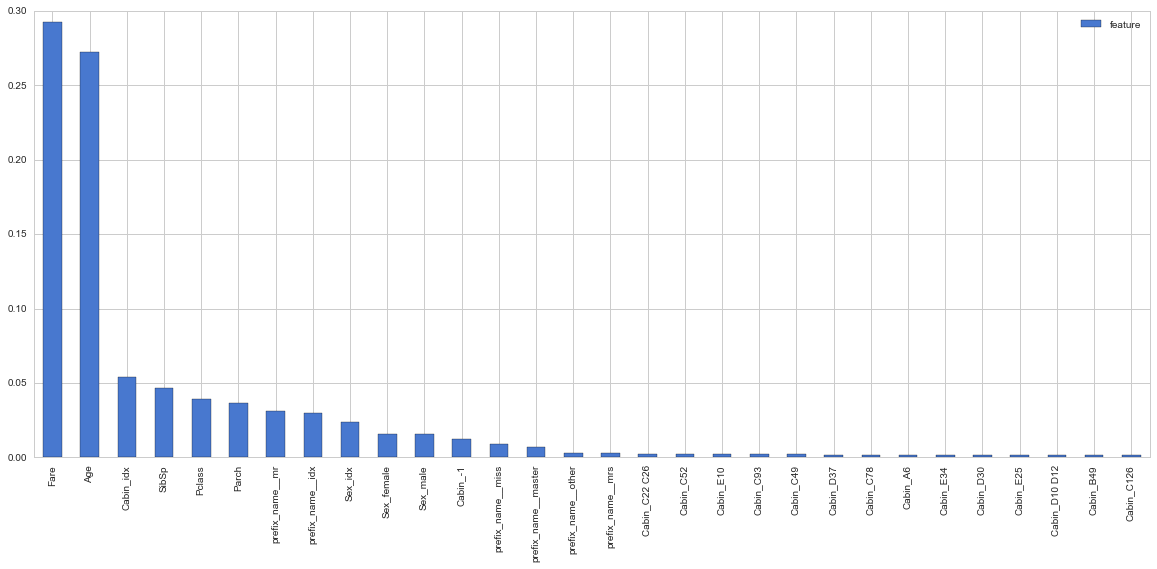

In [17]:
all_df = handle_cat_var(all_df, 'Cabin')
print iteration_modeling(all_df)

draw_importance_features(all_df)

In [18]:
all_df['deck'] = all_df['Cabin'].map(lambda x:  "missing" if x == -1 else x.strip()[0])
all_df['deck'].value_counts()

missing    1014
C            94
B            65
D            46
E            41
A            22
F            21
G             5
T             1
Name: deck, dtype: int64

{'max': 0.83054230691892672, 'mean': 0.80679116543199902, 'min': 0.79349447316410782}


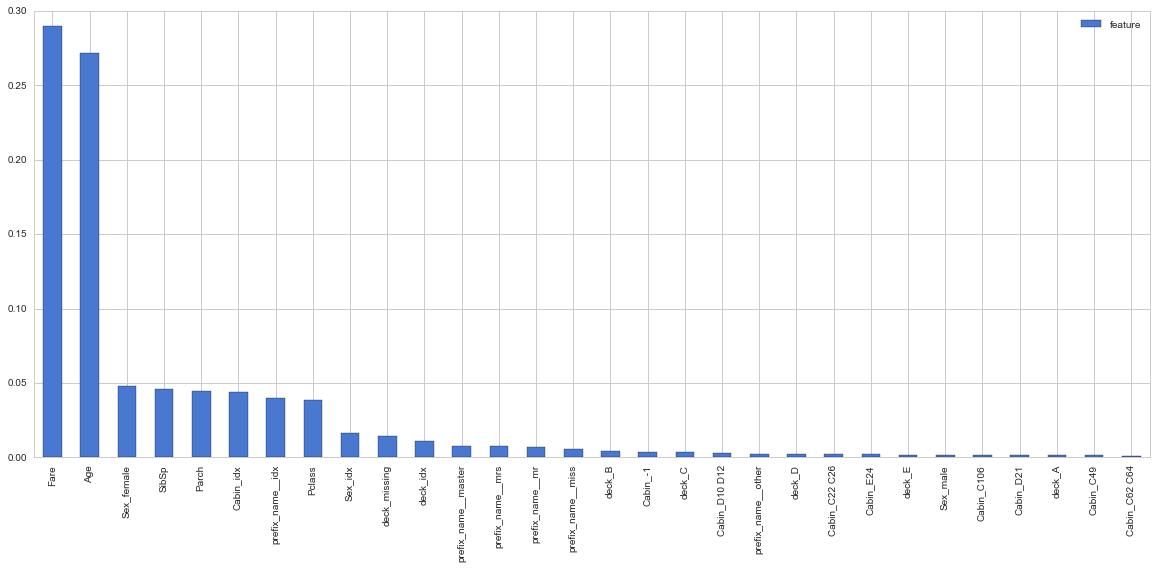

In [19]:
all_df = handle_cat_var(all_df, 'deck')
print iteration_modeling(all_df)

draw_importance_features(all_df)

The result looks the same or a bit worse (**0.81** vs **0.81**).
Let's focus on **Embarked**

In [20]:
all_df['Embarked'].replace(-1, 'missing', inplace=True)
all_df['Embarked'].value_counts()

S          914
C          270
Q          123
missing      2
Name: Embarked, dtype: int64

{'max': 0.8215344279550193, 'mean': 0.8052849972947127, 'min': 0.7912218192367011}


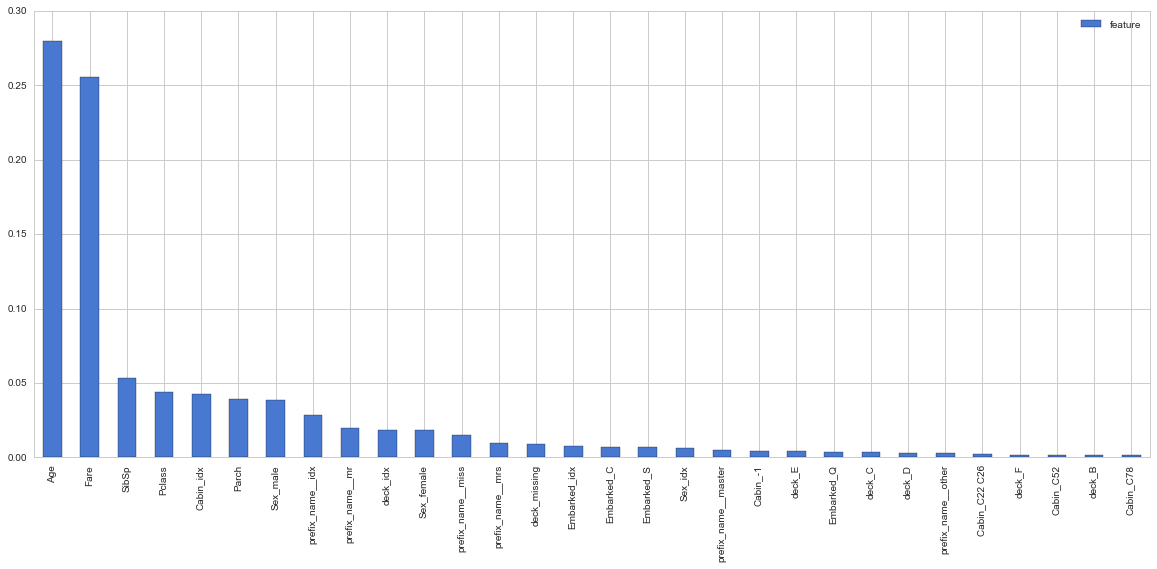

In [21]:
all_df = handle_cat_var(all_df, 'Embarked')
print iteration_modeling(all_df)

draw_importance_features(all_df)

Looks more or less the same (event a bit worse)... let's focus on the **Parch** and **SibSp**

* **Sibsp** - Number of Siblings/Spouses Aboard
* **Parch** - Number of Parents/Children Aboard

In [22]:
all_df['Parch'].value_counts()

0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: Parch, dtype: int64

In [23]:
all_df['SibSp'].value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64

In [24]:
all_df['sigle'] = all_df.apply(lambda x: 1 if x['Parch'] == x['SibSp'] else 0, axis=1)
all_df['count_relations'] = all_df['Parch'] + all_df['SibSp']

all_df['family_index'] = all_df.apply(lambda x: 'nofamily' if x['count_relations'] == 0 else '{0}-{1}'.format(x['Name'].split(',')[0].strip(), x['count_relations']), axis=1)

In [25]:
all_df['family_index'].value_counts()

nofamily             790
Sage-10               11
Andersson-6            9
Goodwin-7              8
Asplund-6              7
Fortune-5              6
Rice-5                 6
Panula-5               6
Skoog-5                6
Davies-2               5
Palsson-4              5
Ryerson-4              5
Ford-4                 5
Lefebre-4              5
Harper-1               4
Allison-3              4
Brown-2                4
Dean-3                 4
Baclini-3              4
Herman-3               4
Becker-3               4
Johnston-3             4
Laroche-3              4
Carter-3               4
West-3                 4
Johnson-2              3
Widener-2              3
Hickman-2              3
Hart-2                 3
Thayer-2               3
                    ... 
Jacobsohn-3            1
Frolicher-2            1
Jacobsohn-1            1
Bowerman-1             1
Richards-5             1
Hirvonen-2             1
Chibnall-1             1
Cornell-2              1
Hirvonen-1             1


{'max': 0.81371305705005381, 'mean': 0.80352569419841535, 'min': 0.78683457296597226}


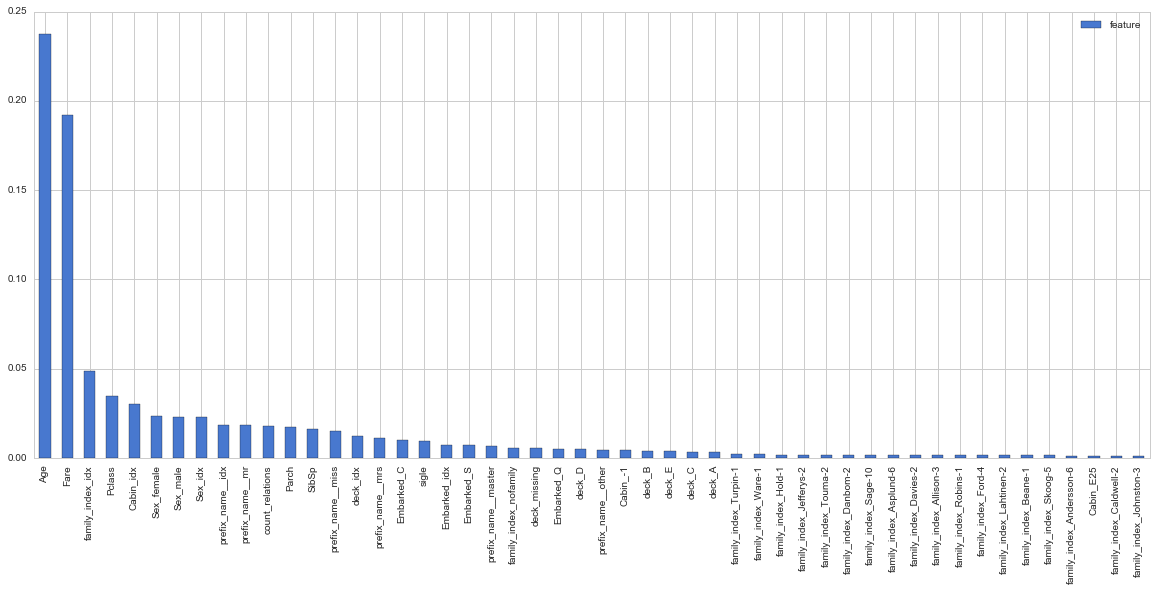

In [26]:
all_df = handle_cat_var(all_df, 'family_index')
print iteration_modeling(all_df)

draw_importance_features(all_df, limit=50)

Let's focus on **Fare**

In [27]:
print 'mean'
print all_df.groupby(['Pclass', 'Sex']).agg(np.mean)['Fare'].reset_index()
print
print 'median'
print all_df.groupby(['Pclass', 'Sex']).agg(np.median)['Fare'].reset_index()

mean
   Pclass     Sex        Fare
0       1  female  109.412385
1       1    male   69.888385
2       2  female   23.234827
3       2    male   19.904946
4       3  female   15.324250
5       3    male   12.388250

median
   Pclass     Sex      Fare
0       1  female  80.92915
1       1    male  49.50420
2       2  female  23.00000
3       2    male  13.00000
4       3  female  10.48960
5       3    male   7.89580


Interesting... for some reason the tickets are bought by female is more expensive.

In [28]:
all_df['fare_log'] = all_df['Fare'].map( lambda x: x if x <= 0 else int(np.log2(x)) )
all_df['fare_log'].value_counts()

 3.0    354
 2.0    342
 4.0    283
 5.0    135
 6.0    109
 7.0     50
 0.0     17
 8.0     13
 9.0      4
-1.0      1
 1.0      1
Name: fare_log, dtype: int64

In [29]:
def call_diff(x, dict_fare, percentage=False):
    key = (x['Pclass'], x['Sex'])
    diff = x['Fare'] - dict_fare[key]
    
    diff_per = np.abs(diff / x['Fare']) if x['Fare'] > 0 else 0.0
    return diff_per if percentage else diff

fare_median = all_df.groupby(['Pclass', 'Sex']).agg(np.median)['Fare'].to_dict()
fare_mean = all_df.groupby(['Pclass', 'Sex']).agg(np.mean)['Fare'].to_dict()

all_df['diff_fare_median'] = all_df.apply(lambda x: call_diff(x, fare_median), axis=1)
all_df['diff_fare_mean'] = all_df.apply(lambda x: call_diff(x, fare_mean), axis=1)
all_df['diff_fare_mm'] = all_df['diff_fare_median'] - all_df['diff_fare_mean']
all_df['diff_fare_median_pr'] = all_df.apply(lambda x: call_diff(x, fare_median, True), axis=1)
all_df['diff_fare_mean_pr'] = all_df.apply(lambda x: call_diff(x, fare_mean, True), axis=1)

{'max': 0.80695878802193222, 'mean': 0.79283346224377937, 'min': 0.77218995619172648}


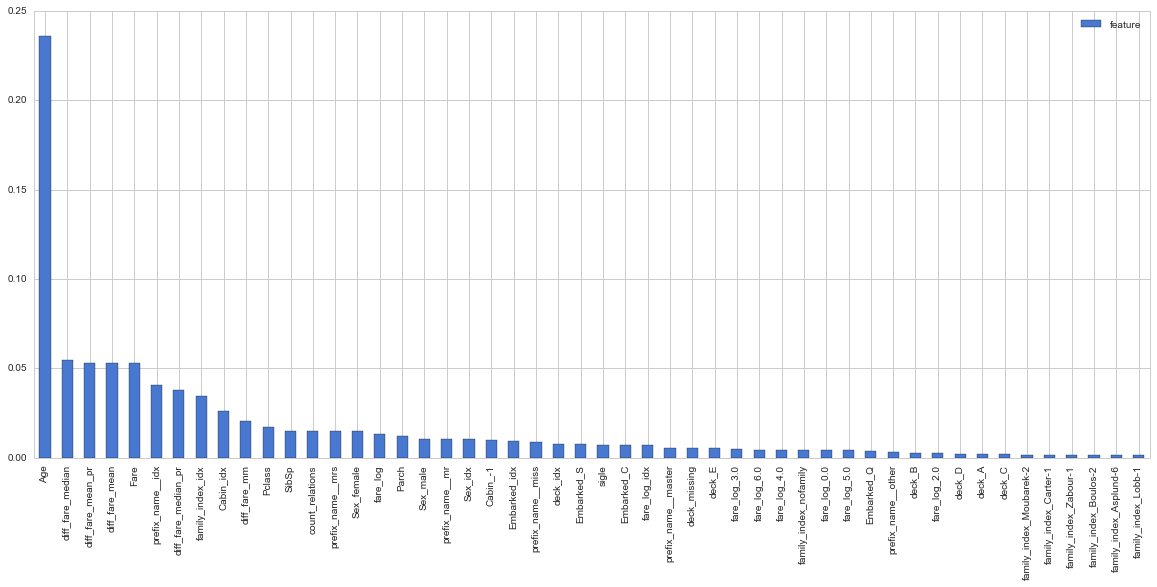

In [30]:
all_df = handle_cat_var(all_df, 'fare_log')
print iteration_modeling(all_df)

draw_importance_features(all_df, limit=50)

Looks more or less the same, let's focus on ticket

148    11
72      8
58      8
277     7
13      7
49      7
70      7
24      7
16      6
266     6
26      6
62      6
503     5
84      5
284     5
7       5
327     5
160     5
324     5
231     4
57      4
42      4
550     4
163     4
334     4
90      4
614     4
283     4
272     4
240     4
       ..
576     1
574     1
603     1
605     1
635     1
607     1
633     1
632     1
631     1
630     1
629     1
628     1
627     1
626     1
624     1
623     1
622     1
621     1
620     1
619     1
618     1
617     1
616     1
615     1
613     1
612     1
611     1
610     1
609     1
0       1
Name: ticket_index, dtype: int64


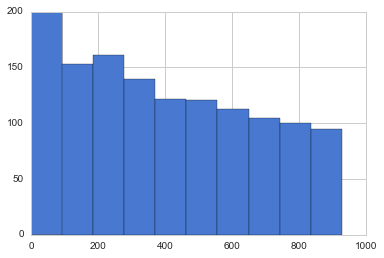

In [31]:
ticket_idx, ticket_labels = pd.factorize(all_df.Ticket)
all_df['ticket_index'] = ticket_idx

print all_df['ticket_index'].value_counts()
all_df['ticket_index'].hist()

{'max': 0.81037365588251864, 'mean': 0.79829811258793659, 'min': 0.78227071761094014}


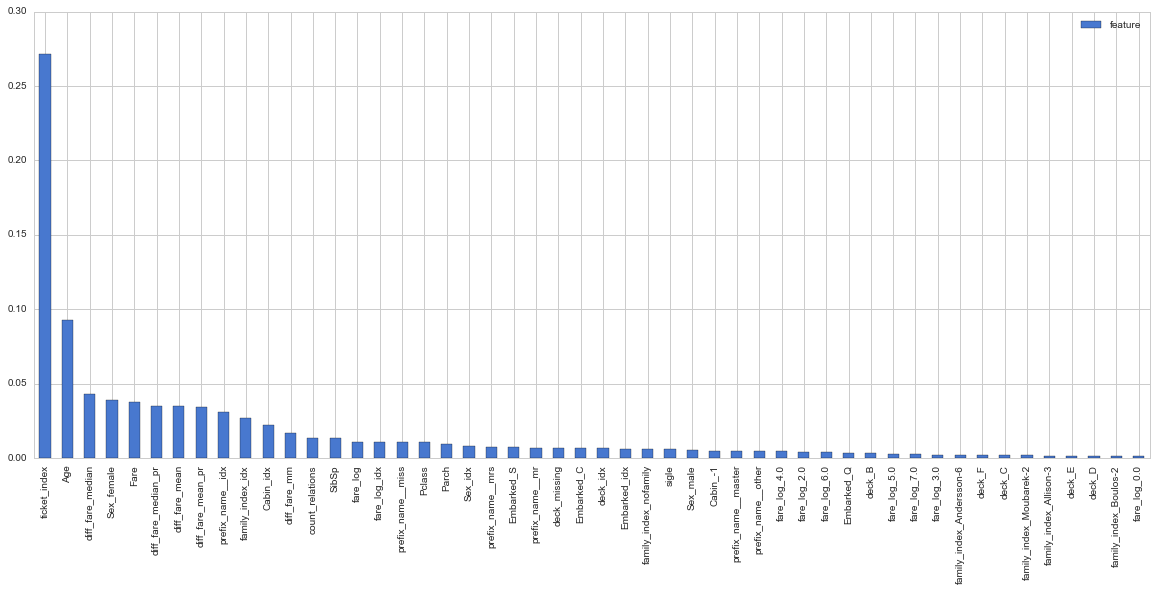

In [32]:
print iteration_modeling(all_df)

draw_importance_features(all_df, limit=50)

In [33]:
def map_age(x):
    if x < 0: return 'missing'
    if x < 6:  return '0_5'
    if x < 16: return '6_15'
    if x < 21: return '16_20'
    if x < 26: return '21_25'
    if x < 31: return '26_30'
    if x < 36: return '31_35'
    if x < 41: return '36_40'
    if x < 50: return '41_50'
    if x < 61: return '51_60'
    return '61+'

all_df['age_bucket'] = all_df['Age'].map(map_age)
print all_df['age_bucket'].value_counts()


missing    263
21_25      194
26_30      168
16_20      134
41_50      114
31_35      113
36_40       98
51_60       78
6_15        59
0_5         56
61+         32
Name: age_bucket, dtype: int64


{'max': 0.81485555469260618, 'mean': 0.79948481569707208, 'min': 0.78001097245997664}


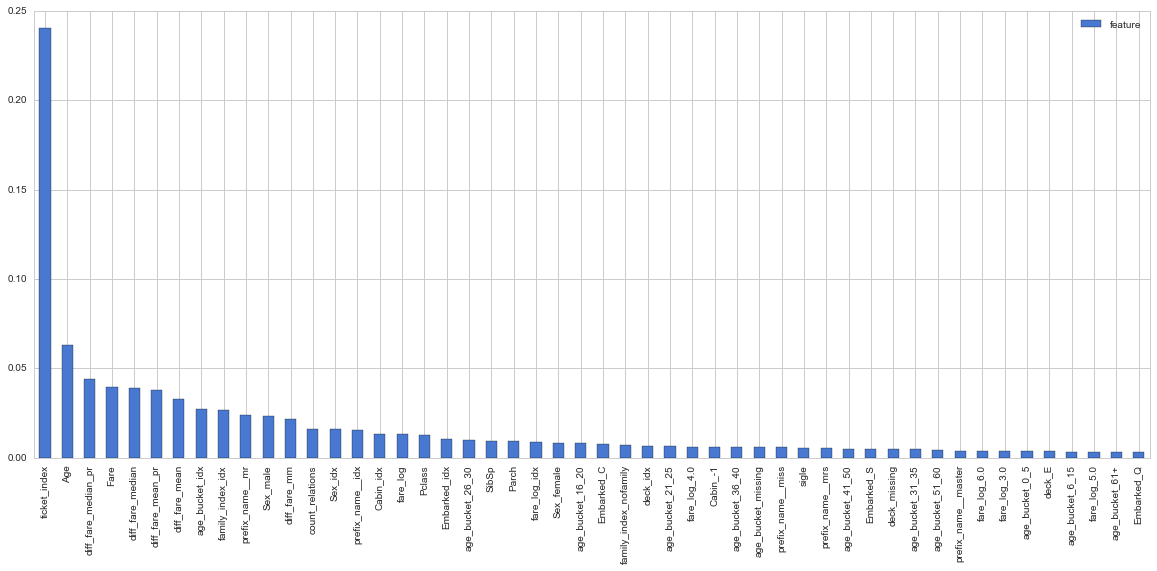

In [34]:
all_df = handle_cat_var(all_df, 'age_bucket')
print iteration_modeling(all_df)

draw_importance_features(all_df, limit=50)

## Feature selection

In [35]:
imp_feats= get_importance_features(all_df, RandomForestClassifier(), 100)
#name_feats = list(feats['feature'].index) ## poprawka
name_feats = list(imp_feats['feature'].index)

k_feats = {}
for num_feats in range(1, 100):
    curr_feats = name_feats[:num_feats] + ['is_test']
    k_feats[num_feats] = iteration_modeling(all_df[ curr_feats ])

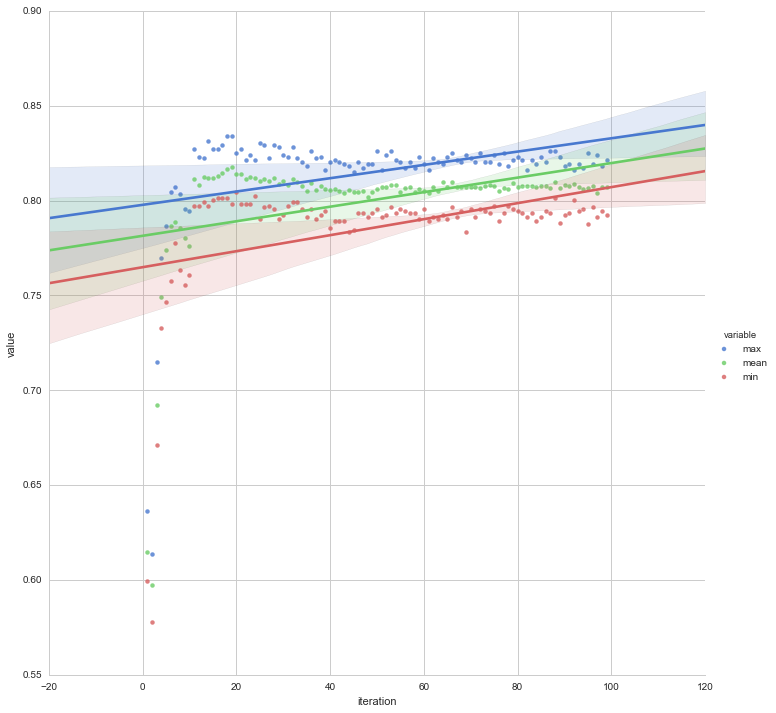

In [36]:
feats_score = pd.DataFrame(k_feats).T
feats_score['iteration'] = feats_score.index

feats_df = pd.melt(feats_score, id_vars='iteration')
sns.lmplot(x="iteration", y="value", hue="variable", data=feats_df, size=10, order=1)

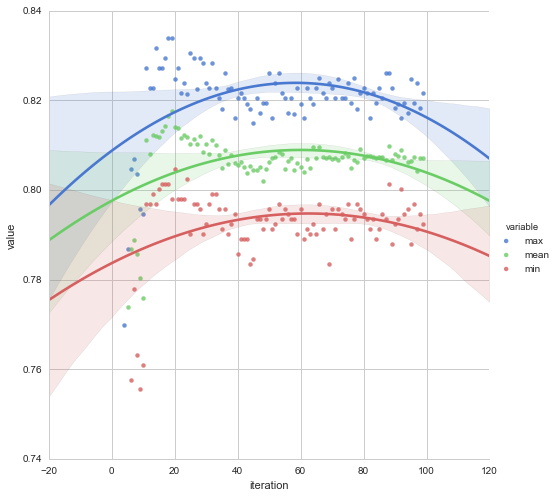

In [37]:
sns.lmplot(x="iteration", y="value", hue="variable", data=feats_df[ feats_df.value > 0.75 ], size=7, order=2)

In [38]:
print feats_score.sort_values(by='mean', ascending=False).head(10)

print feats_score.sort_values(by='mean', ascending=True).head(10)

         max      mean       min  iteration
19  0.833944  0.817609  0.798058         19
18  0.833945  0.816643  0.801366         18
17  0.829437  0.814369  0.801379         17
20  0.824886  0.814055  0.804769         20
21  0.827196  0.813836  0.797976         21
16  0.827178  0.813124  0.801385         16
13  0.822708  0.812311  0.799125         13
23  0.823813  0.812192  0.798039         23
28  0.829406  0.811999  0.795805         28
14  0.831647  0.811969  0.796891         14
         max      mean       min  iteration
2   0.613943  0.597234  0.578069          2
1   0.636264  0.614905  0.599298          1
3   0.715012  0.692105  0.671172          3
4   0.769968  0.749421  0.732952          4
5   0.786790  0.773996  0.746429          5
10  0.794599  0.775881  0.760998         10
9   0.795817  0.780428  0.755487          9
8   0.803657  0.785687  0.763239          8
6   0.804749  0.786755  0.757646          6
7   0.807022  0.788751  0.777802          7


Looks interesting from 13 to 20 features.
Let's try check the same, but with module 20...


In [39]:
from collections import defaultdict

imp_feats= get_importance_features(all_df, RandomForestClassifier(), limit=200)
name_feats = list(imp_feats['feature'].index)
feats_shift = defaultdict(list)

for idx, name in enumerate(name_feats):    
    for idx_shift in range(20):
        key = idx + idx_shift + 1
        if key % 20: continue
        
        feats_shift[key].append(name)
        

for key, cur_feats in feats_shift.items():
    k_feats['shift_{0}'.format(key)] = iteration_modeling(all_df[ feats_shift[key] + ['is_test'] ])

In [40]:
X,y = get_X_y(all_df)

for num_feats in [10, 12, 15, 17, 20, 25]:
    rfe = RFE(RandomForestClassifier(), num_feats)
    rfe = rfe.fit(X, y)
    
    print num_feats
    print [a for a,b in zip(select_features(all_df), rfe.ranking_) if b == True]
    sys.stdout.flush()

10
['Age', 'Fare', 'prefix_name__idx', 'Cabin_idx', 'family_index_idx', 'diff_fare_median', 'diff_fare_mean', 'diff_fare_median_pr', 'diff_fare_mean_pr', 'ticket_index']
12
['Age', 'Fare', 'prefix_name__idx', 'prefix_name__mr', 'Cabin_idx', 'family_index_idx', 'diff_fare_median', 'diff_fare_mean', 'diff_fare_median_pr', 'diff_fare_mean_pr', 'ticket_index', 'age_bucket_idx']
15
['Age', 'Fare', 'SibSp', 'Sex_female', 'prefix_name__idx', 'Cabin_idx', 'count_relations', 'family_index_idx', 'diff_fare_median', 'diff_fare_mean', 'diff_fare_mm', 'diff_fare_median_pr', 'diff_fare_mean_pr', 'ticket_index', 'age_bucket_idx']
17
['Age', 'Fare', 'Pclass', 'SibSp', 'Sex_female', 'prefix_name__idx', 'Cabin_idx', 'count_relations', 'family_index_idx', 'fare_log', 'diff_fare_median', 'diff_fare_mean', 'diff_fare_mm', 'diff_fare_median_pr', 'diff_fare_mean_pr', 'ticket_index', 'age_bucket_idx']
20
['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Sex_female', 'Sex_male', 'prefix_name__idx', 'prefix_name__mr

In [41]:
golden_features = {
    10: ['Age', 'Fare', 'prefix_name__idx', 'family_index_idx', 'diff_fare_median', 'diff_fare_mean', 'diff_fare_median_pr', 'diff_fare_mean_pr', 'ticket_index', 'age_bucket_idx'],
    12: ['Age', 'Fare', 'prefix_name__mr', 'Cabin_idx', 'family_index_idx', 'diff_fare_median', 'diff_fare_mean', 'diff_fare_mm', 'diff_fare_median_pr', 'diff_fare_mean_pr', 'ticket_index', 'age_bucket_idx'],
    15: ['Age', 'Fare', 'Pclass', 'Sex_idx', 'prefix_name__mr', 'Cabin_idx', 'count_relations', 'family_index_idx', 'diff_fare_median', 'diff_fare_mean', 'diff_fare_mm', 'diff_fare_median_pr', 'diff_fare_mean_pr', 'ticket_index', 'age_bucket_idx'],
    17: ['Age', 'Fare', 'SibSp', 'Sex_male', 'prefix_name__idx', 'Cabin_idx', 'deck_idx', 'count_relations', 'family_index_idx', 'fare_log', 'diff_fare_median', 'diff_fare_mean', 'diff_fare_mm', 'diff_fare_median_pr', 'diff_fare_mean_pr', 'ticket_index', 'age_bucket_idx'],
    20: ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'prefix_name__idx', 'prefix_name__mr', 'Cabin_idx', 'deck_idx', 'Embarked_idx', 'count_relations', 'family_index_idx', 'fare_log', 'diff_fare_median', 'diff_fare_mean', 'diff_fare_mm', 'diff_fare_median_pr', 'diff_fare_mean_pr', 'ticket_index', 'age_bucket_idx'],
    25: ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Sex_female', 'prefix_name__idx', 'prefix_name__mr', 'Cabin_idx', 'deck_idx', 'Embarked_idx', 'Embarked_C', 'sigle', 'count_relations', 'family_index_idx', 'fare_log', 'diff_fare_median', 'diff_fare_mean', 'diff_fare_mm', 'diff_fare_median_pr', 'diff_fare_mean_pr', 'fare_log_idx', 'ticket_index', 'age_bucket_idx', 'age_bucket_26_30']
}

In [42]:
for num, feats in golden_features.items():
    print num, iteration_modeling(all_df[feats + ['is_test']])
    sys.stdout.flush()

10 {'max': 0.82612339158950654, 'mean': 0.80933054399735416, 'min': 0.79019915334030544}
12 {'max': 0.83508091213981772, 'mean': 0.81489337078769897, 'min': 0.80252724762544125}
15 {'max': 0.8283137343352529, 'mean': 0.81483808765224708, 'min': 0.80027413418105697}
17 {'max': 0.82497454594974717, 'mean': 0.81330983037607696, 'min': 0.79915025496606673}
20 {'max': 0.82388882564534138, 'mean': 0.81305969091518859, 'min': 0.80026757340182075}
25 {'max': 0.8261109793044652, 'mean': 0.8112505211682064, 'min': 0.79801403439337792}


## Grid Search

In [43]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
curr_features = golden_features[12] + ['is_test', 'PassengerId']

df = all_df[ curr_features ]
X_train, y_train = get_X_y(df[ df.is_test == False ])

cv = StratifiedKFold(y_train, n_folds=15, random_state=0, shuffle=True)
grid_params = {'min_samples_split': [4, 6, 8, 10], 'n_estimators': [20, 30, 50, 60], 'criterion': ['gini'], 'min_samples_leaf': [1]}

model = RandomForestClassifier(n_jobs=-1)
grid  = GridSearchCV(model, grid_params, cv=cv, scoring='accuracy') 

grid.fit(X_train, y_train)

print 'Best score: ', grid.best_score_, 'Best params: ', grid.best_params_

predict_and_save(all_df[curr_features], grid.best_estimator_, '../rf_grid_12.csv')

# 15 features
#kaggle=0.77512, private=0.84  cv=10
#kaggle=0.77033, private=0.8451  cv=3

#12 features
#kaggle= 0.77512, private=0.8496  cv=15

Best score:  0.850729517396 Best params:  {'min_samples_split': 6, 'n_estimators': 30, 'criterion': 'gini', 'min_samples_leaf': 1}


### ExtraTrees

In [45]:
#curr_features = golden_features[20] + ['is_test', 'PassengerId']
curr_features = ['is_test', 'PassengerId'] + ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'prefix_name__idx', 'prefix_name__mr', 'Cabin_idx', 'deck_idx', 'Embarked_idx', 'count_relations', 'family_index_idx', 'fare_log', 'diff_fare_median', 'diff_fare_mean', 'diff_fare_mm', 'diff_fare_median_pr', 'diff_fare_mean_pr', 'age_bucket_idx']

df = all_df[ curr_features ]
X_train, y_train = get_X_y(df[ df.is_test == False ])

cv = StratifiedKFold(y_train, n_folds=10, random_state=0, shuffle=True)
grid_params = {'min_samples_split': [4, 8, 10], 'n_estimators': [20, 30, 50], 'criterion': ['gini'], 'min_samples_leaf': [1]}

model = ExtraTreesClassifier(n_jobs=-1)
grid  = GridSearchCV(model, grid_params, cv=cv, scoring='accuracy') 
grid.fit(X_train, y_train)

print 'Best score: ', grid.best_score_, 'Best params: ', grid.best_params_

predict_and_save(all_df[curr_features], grid.best_estimator_, '../et_grid_20_without_ticket.csv')

# 20 features
#kaggle= 0.77512, private=0.8373  cv=10

Best score:  0.83164983165 Best params:  {'min_samples_split': 10, 'n_estimators': 50, 'criterion': 'gini', 'min_samples_leaf': 1}


### XGBoost


In [46]:
X_train, y_train = get_X_y(all_df[ all_df.is_test == False ])

cv = StratifiedKFold(y_train, n_folds=15, random_state=0, shuffle=True)

ald_xgb_model = xgb.XGBClassifier()
ald_xgb_params = [
    {"n_estimators": [230, 250, 300, 500],
     "max_depth": [4, 6, 8],
     "learning_rate": [0.01, 0.02, 0.05, 0.07]}
]

alg_xgb_grid = GridSearchCV(ald_xgb_model, ald_xgb_params, cv=cv, refit=True, verbose=1, n_jobs=1)
alg_xgb_grid.fit(X_train, y_train)
alg_xgb_best = alg_xgb_grid.best_estimator_

print("Accuracy (xgboost auto): {} with params {}".format(alg_xgb_grid.best_score_, alg_xgb_grid.best_params_))

predict_and_save(all_df, alg_xgb_best, '../xgb_grid_all_without_ticket.csv')

#all features
#kaggle = 0.79426, private = 0.8383

Fitting 15 folds for each of 48 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  4.8min
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed: 32.5min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed: 71.3min
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 120.2min finished


Accuracy (xgboost auto): 0.836139169473 with params {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 4}


## Voting

In [47]:
curr_features = all_df.columns

df = all_df[ curr_features ]
X_train, y_train = get_X_y(df[ df.is_test == False ])

estimators = [
    ('xgb', xgb.XGBClassifier(**{'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 4})), 
    ('rf', RandomForestClassifier(**{'min_samples_split': 8, 'n_estimators': 50, 'criterion': 'gini', 'min_samples_leaf': 1})),
    ('et', ExtraTreesClassifier(**{'min_samples_split': 10, 'n_estimators': 30, 'criterion': 'gini', 'min_samples_leaf': 1}))
]

grid_params = {
    'xgb__n_estimators': [250, 300, 350],
    'xgb__max_depth': [4, 6, 8],
    'xgb__learning_rate': [0.01, 0.02, 0.05],
    'rf__n_estimators': [40, 50],
    'rf__min_samples_split': [8, 10],
    'et__n_estimators': [30, 40],
    'et__min_samples_split': [8, 10],
}

cv = StratifiedKFold(y_train, n_folds=5, random_state=0, shuffle=True)

model = VotingClassifier(estimators=estimators, voting='soft', weights=[2, 1, 1])
grid = GridSearchCV(model, grid_params, cv=cv, refit=True, verbose=1, n_jobs=1)
grid.fit(X_train, y_train)

print 'Best score: ', grid.best_score_, 'Best params: ', grid.best_params_
#predict_and_save(all_df[curr_features], model, '../voting_all.csv') # 0.78947, 0.79426

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  6.8min
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed: 27.8min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed: 64.2min
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed: 114.1min
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed: 179.0min
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed: 258.4min
[Parallel(n_jobs=1)]: Done 2160 out of 2160 | elapsed: 314.0min finished


Best score:  0.833894500561 Best params:  {'et__n_estimators': 40, 'rf__n_estimators': 50, 'xgb__n_estimators': 250, 'rf__min_samples_split': 8, 'xgb__learning_rate': 0.05, 'et__min_samples_split': 8, 'xgb__max_depth': 6}
